In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
import string
import re
import nltk

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

file_path = './amazon_user_reviews.parquet'

df = pd.read_parquet(file_path)

In [3]:
# Basic length features
df['char_count'] = df['original_text'].str.len()
df['word_count'] = df['original_text'].str.split().str.len()
df['avg_word_length'] = df['char_count'] / df['word_count']

# Punctuation
df['exclamation_count'] = df['original_text'].str.count('!')
df['question_count'] = df['original_text'].str.count('\?')
df['period_count'] = df['original_text'].str.count('\.')
df['comma_count'] = df['original_text'].str.count(',')
df['ellipsis_count'] = df['original_text'].str.count('\.\.\.')
df['total_punctuation'] = (df['exclamation_count'] + df['question_count'] +
                            df['period_count'] + df['comma_count'])

# Capitalization features
df['all_caps_words'] = df['original_text'].str.findall(r'\b[A-Z]{2,}\b').str.len()
df['uppercase_count'] = df['original_text'].str.findall(r'[A-Z]').str.len()
df['uppercase_ratio'] = df['uppercase_count'] / df['char_count']

# Binary indicators
df['has_exclamation'] = (df['exclamation_count'] > 0).astype(int)
df['has_question'] = (df['question_count'] > 0).astype(int)
df['has_all_caps'] = (df['all_caps_words'] > 0).astype(int)

text_features = ['exclamation_count', 'question_count', 'word_count',
                 'char_count', 'all_caps_words', 'uppercase_ratio',
                 'total_punctuation', 'avg_word_length']

<>:8: SyntaxWarning: invalid escape sequence '\?'
<>:9: SyntaxWarning: invalid escape sequence '\.'
<>:11: SyntaxWarning: invalid escape sequence '\.'
<>:8: SyntaxWarning: invalid escape sequence '\?'
<>:9: SyntaxWarning: invalid escape sequence '\.'
<>:11: SyntaxWarning: invalid escape sequence '\.'
/var/folders/28/4py847v94qvbv5v7yzm79jg80000gn/T/ipykernel_55126/1649078473.py:8: SyntaxWarning: invalid escape sequence '\?'
  df['question_count'] = df['original_text'].str.count('\?')
/var/folders/28/4py847v94qvbv5v7yzm79jg80000gn/T/ipykernel_55126/1649078473.py:9: SyntaxWarning: invalid escape sequence '\.'
  df['period_count'] = df['original_text'].str.count('\.')
/var/folders/28/4py847v94qvbv5v7yzm79jg80000gn/T/ipykernel_55126/1649078473.py:11: SyntaxWarning: invalid escape sequence '\.'
  df['ellipsis_count'] = df['original_text'].str.count('\.\.\.')


In [4]:
# Convert verified_purchase to integer (0: False/1: True)
df["int_verified_purchase"]= df['verified_purchase'].astype(int)

In [5]:
# Parse `datetime` and extract hour, month, season
# Nominal Season: 1:Spring (March–May), 2:Summer (June–August), 3:Fall (September–November), and 4:Winter (December–February). 

df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
# hour: integer hour from datetime
df['hour'] = df['datetime'].dt.hour
# month: integer month (1-12)
df['month'] = df['datetime'].dt.month
# season mapping based on month
def month_to_season(m):
    if m in [3,4,5]:
        return 1
    elif m in [6,7,8]:
        return 2
    elif m in [9,10,11]:
        return 3
    elif m in [12,1,2]:
        return 4
    else:
        return None
df['season'] = df['month'].apply(month_to_season)

In [6]:
other_features =["helpful_vote","int_verified_purchase","hour", "month", "season"]
features = text_features + other_features

In [7]:
df[other_features]

,helpful_vote,int_verified_purchase,hour,month,season
0,0,1,22,10,3
1,0,1,19,8,2
2,0,1,15,9,3
3,3,1,21,1,4
4,0,1,2,8,2
...,...,...,...,...,...
16944,0,1,16,2,4
16945,2,1,17,4,1
16946,0,0,16,1,4
16947,1,1,0,1,4


In [8]:
analysis_by_rating = df.groupby('rating')[features].agg(['mean', 'median', 'std'])
print("\n", analysis_by_rating.round(2))


        exclamation_count              question_count              word_count  \
                    mean median   std           mean median   std       mean   
rating                                                                         
1.0                 0.56    0.0  1.60           0.10    0.0  0.46      51.11   
2.0                 0.31    0.0  1.07           0.07    0.0  0.35      67.94   
3.0                 0.28    0.0  1.31           0.07    0.0  0.34      87.30   
4.0                 0.35    0.0  1.53           0.07    0.0  0.40      90.74   
5.0                 0.59    0.0  1.56           0.04    0.0  0.31      56.93   

                      char_count  ... int_verified_purchase   hour         \
       median     std       mean  ...                   std   mean median   
rating                            ...                                       
1.0      27.0   78.26     275.55  ...                  0.37  12.84   15.0   
2.0      36.0   87.39     367.61  ...            

In [9]:
print("Other features: CORRELATION WITH RATING")

# Calculate correlation of each feature with rating
correlations = df[other_features + ['rating']].corr()['rating'].sort_values(ascending=False)
print("\n", correlations)

Other features: CORRELATION WITH RATING

 rating                   1.000000
season                   0.028087
hour                     0.004002
month                   -0.004608
int_verified_purchase   -0.016005
helpful_vote            -0.042684
Name: rating, dtype: float64


In [10]:
print("ALl featrues: CORRELATION WITH RATING")

# Calculate correlation of each feature with rating
correlations = df[features + ['rating']].corr()['rating'].sort_values(ascending=False)
print("\n", correlations)

ALl featrues: CORRELATION WITH RATING

 rating                   1.000000
avg_word_length          0.044129
exclamation_count        0.040752
season                   0.028087
uppercase_ratio          0.004856
hour                     0.004002
month                   -0.004608
int_verified_purchase   -0.016005
all_caps_words          -0.024566
char_count              -0.035824
word_count              -0.039700
helpful_vote            -0.042684
total_punctuation       -0.043211
question_count          -0.047880
Name: rating, dtype: float64


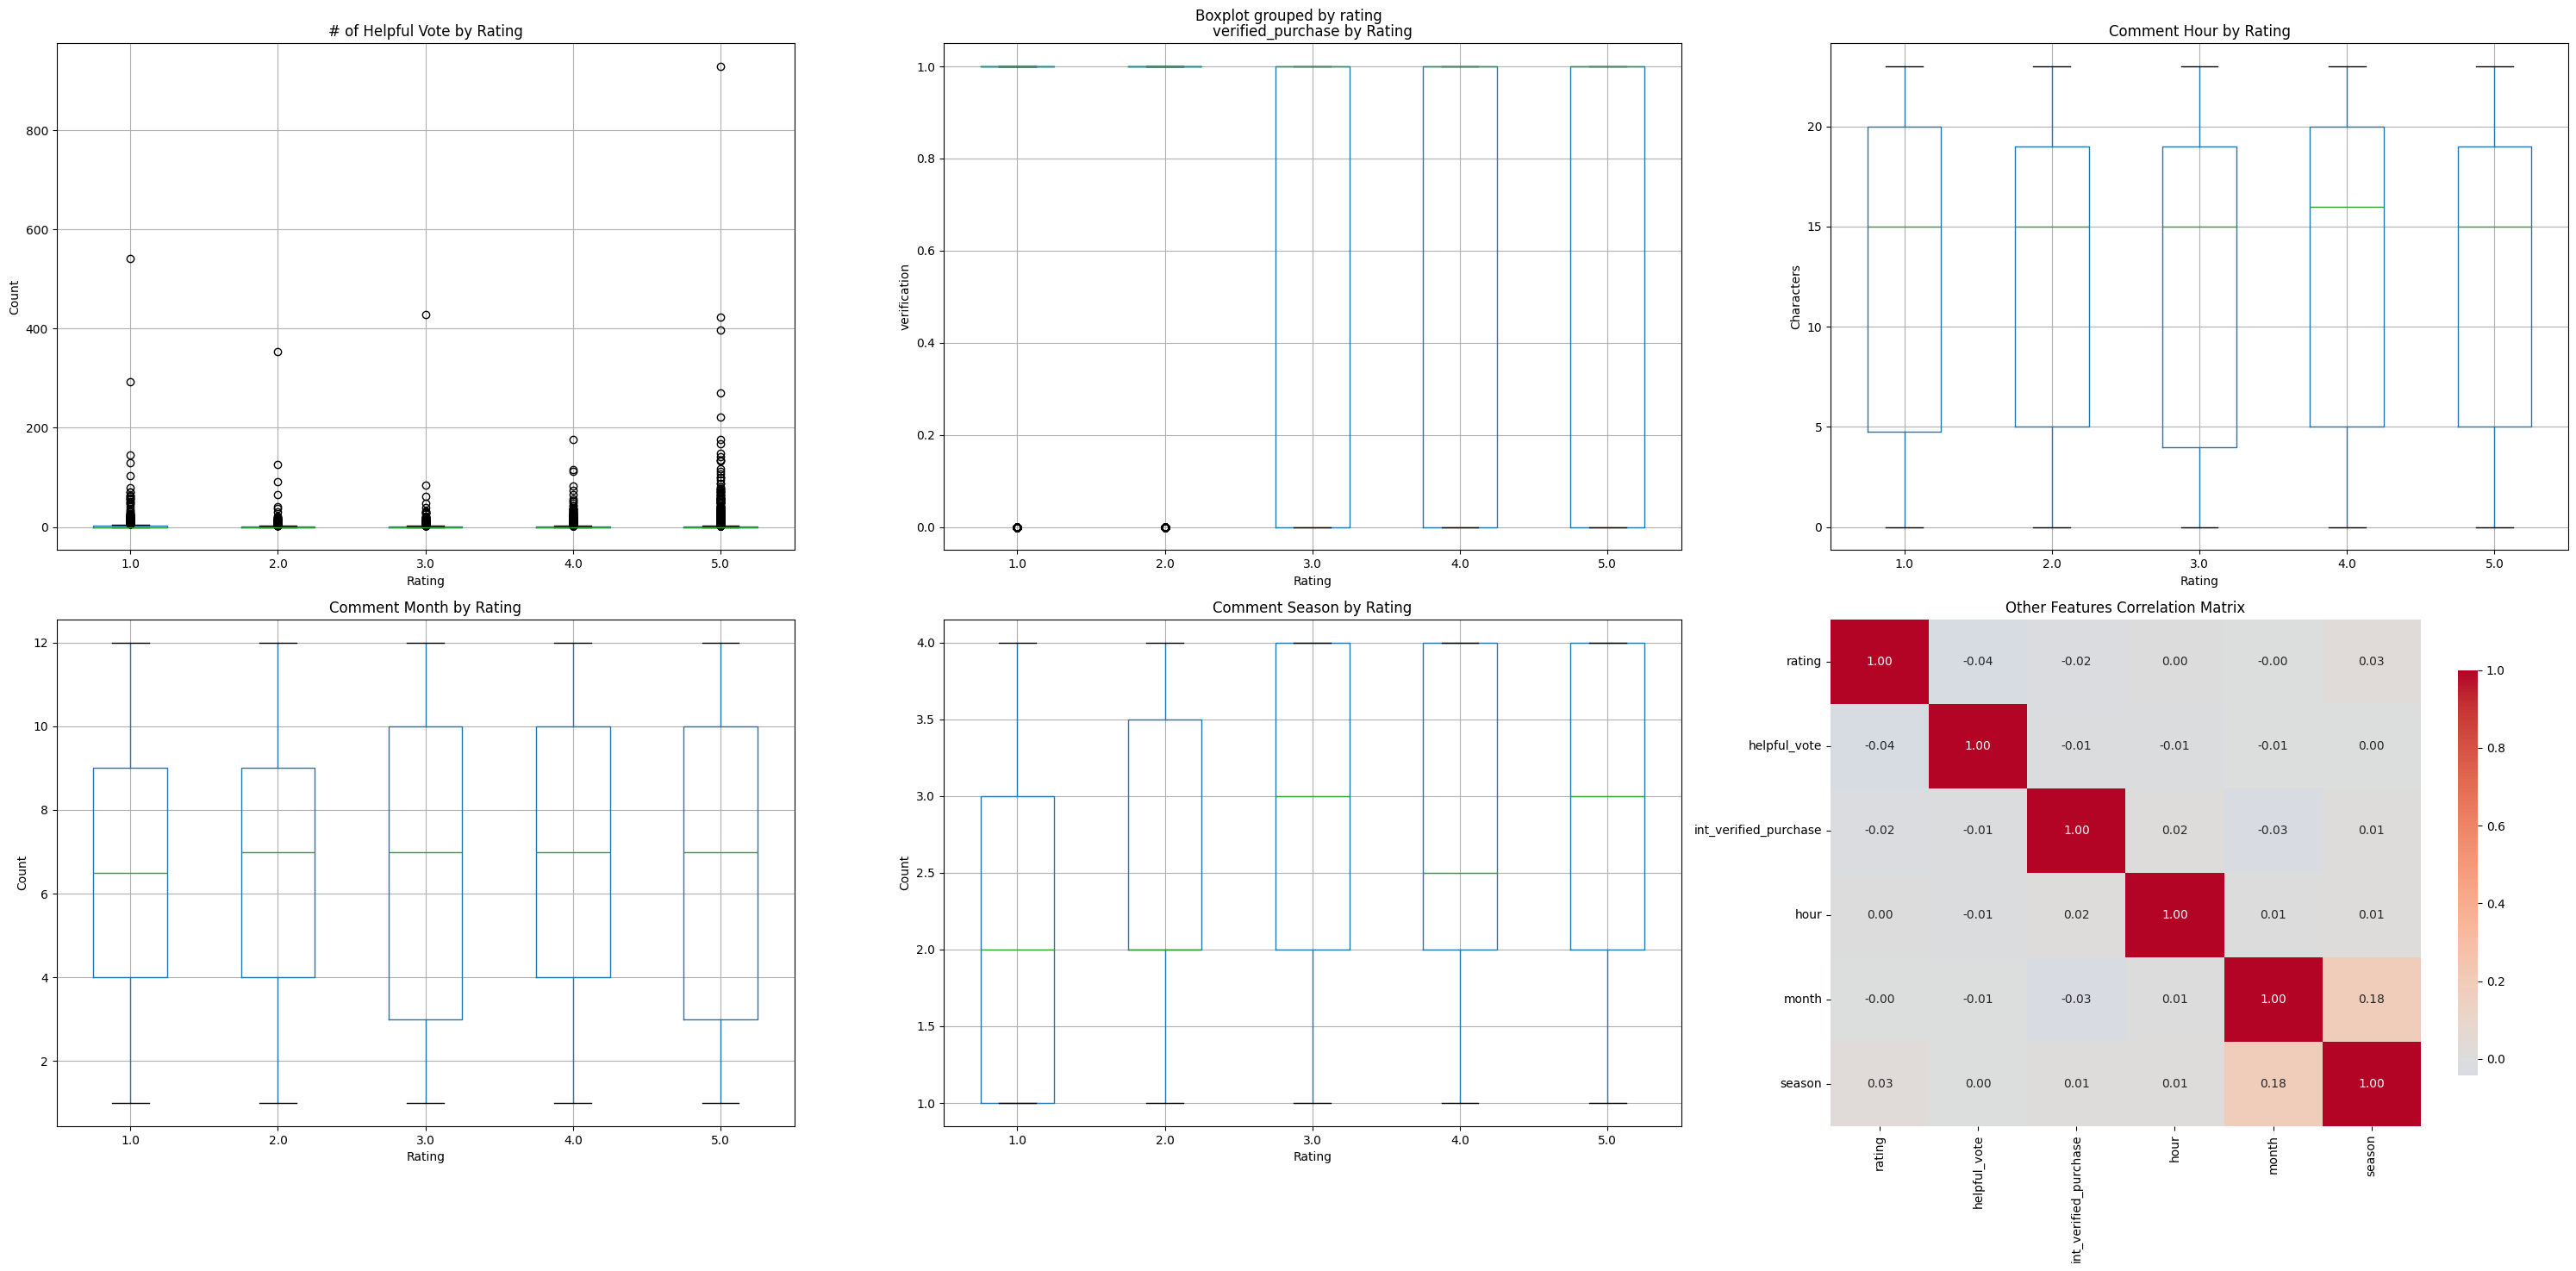

In [11]:
# PART 4: VISUALIZATIONS
fig, axes = plt.subplots(2, 3, figsize=(30, 15))
fig.suptitle('Other features Analysis by Rating', fontsize=16, fontweight='bold')

# 1. helpful_vote
df.boxplot(column='helpful_vote', by='rating', ax=axes[0, 0])
axes[0, 0].set_title('# of Helpful Vote by Rating')
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Count')
plt.sca(axes[0, 0])
plt.xticks(rotation=0)

# 2. int_verified_purchase
df.boxplot(column='int_verified_purchase', by='rating', ax=axes[0, 1])
axes[0, 1].set_title('verified_purchase by Rating')
axes[0, 1].set_xlabel('Rating')
axes[0, 1].set_ylabel('verification')
plt.sca(axes[0, 1])
plt.xticks(rotation=0)

# 3. Comment hour
df.boxplot(column='hour', by='rating', ax=axes[0, 2])
axes[0, 2].set_title('Comment Hour by Rating')
axes[0, 2].set_xlabel('Rating')
axes[0, 2].set_ylabel('Characters')
plt.sca(axes[0, 2])
plt.xticks(rotation=0)

# 4. Comment month
df.boxplot(column='month', by='rating', ax=axes[1, 0])
axes[1, 0].set_title('Comment Month by Rating')
axes[1, 0].set_xlabel('Rating')
axes[1, 0].set_ylabel('Count')
plt.sca(axes[1, 0])
plt.xticks(rotation=0)

# 5. Comment season
df.boxplot(column='season', by='rating', ax=axes[1, 1])
axes[1, 1].set_title('Comment Season by Rating')
axes[1, 1].set_xlabel('Rating')
axes[1, 1].set_ylabel('Count')
plt.sca(axes[1, 1])
plt.xticks(rotation=0)

# 9. Correlation heatmap
corr_features = ["rating","helpful_vote","int_verified_purchase","hour", "month", "season"]
corr_matrix = df[corr_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, ax=axes[1, 2], cbar_kws={'shrink': 0.8})
axes[1, 2].set_title('Other Features Correlation Matrix')
plt.tight_layout()
plt.savefig("other_features_analysis1.png")
plt.show()

In [12]:
# Check for multicollinearity
print("\n4. other_features MULTICOLLINEARITY CHECK")
print("-" * 80)
high_corr_pairs = []
for i in range(len(other_features)):
    for j in range(i+1, len(other_features)):
        corr_val = df[other_features[i]].corr(df[other_features[j]])
        if abs(corr_val) > 0.8:
            high_corr_pairs.append((other_features[i], other_features[j], corr_val))

if high_corr_pairs:
    print("Highly correlated feature pairs (>0.8):")
    for feat1, feat2, corr_val in high_corr_pairs:
        print(f"  - {feat1} <-> {feat2}: {corr_val:.3f}")
    print("\nRecommendation: Keep only one feature from each highly correlated pair")
else:
    print("No highly correlated features found (threshold: 0.8)")



4. other_features MULTICOLLINEARITY CHECK
--------------------------------------------------------------------------------
No highly correlated features found (threshold: 0.8)


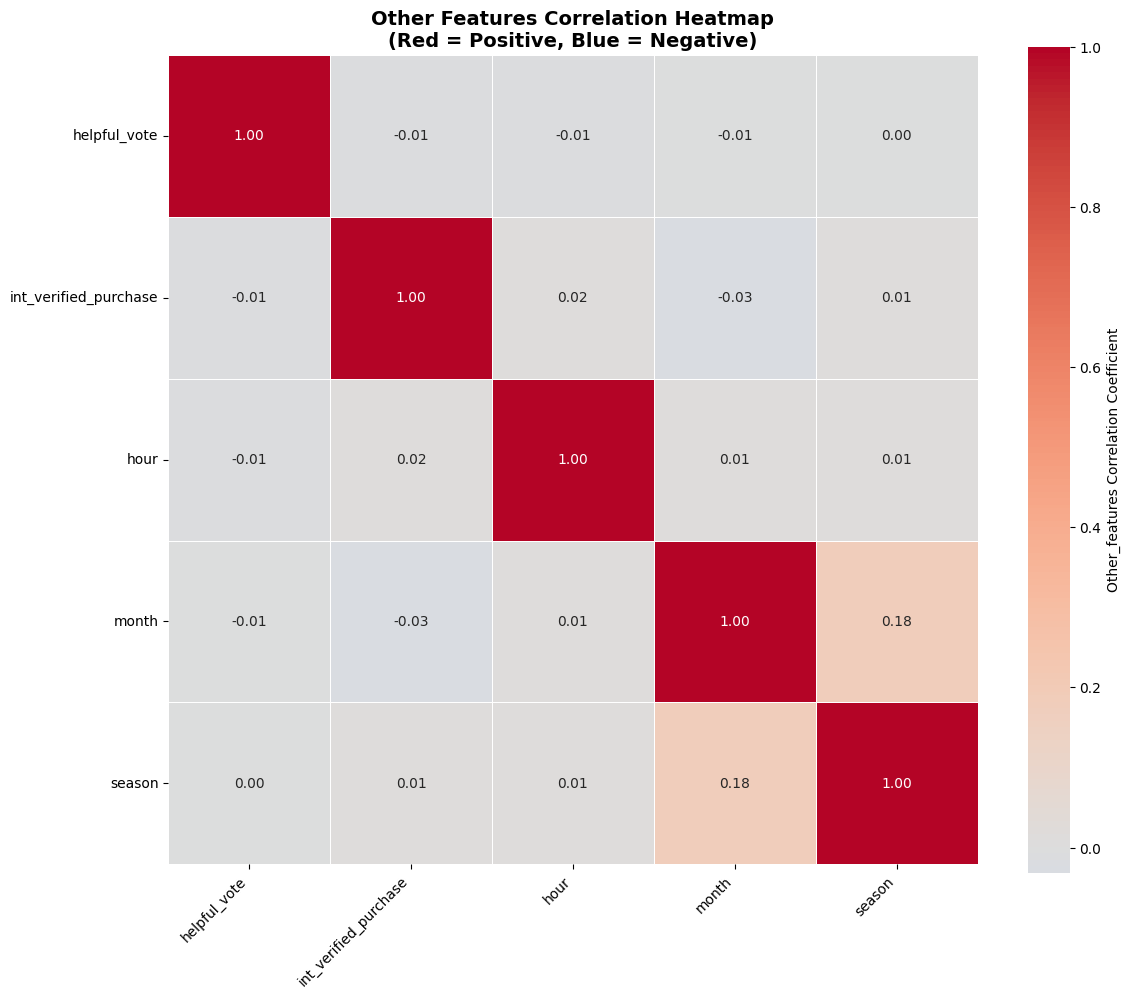

In [13]:
# Create correlation matrix
corr_matrix = df[other_features].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix,
            annot=True,           # Show correlation values
            fmt='.2f',            # 2 decimal places
            cmap='coolwarm',      # Color scheme
            center=0,             # Center colormap at 0
            square=True,          # Make cells square
            linewidths=0.5,       # Grid lines
            cbar_kws={'label': 'Other_features Correlation Coefficient'})

plt.title('Other Features Correlation Heatmap\n(Red = Positive, Blue = Negative)',
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
# Save the file
plt.savefig("multicolinarity_heatmap_other_features.png", dpi=300, bbox_inches='tight')
plt.show()

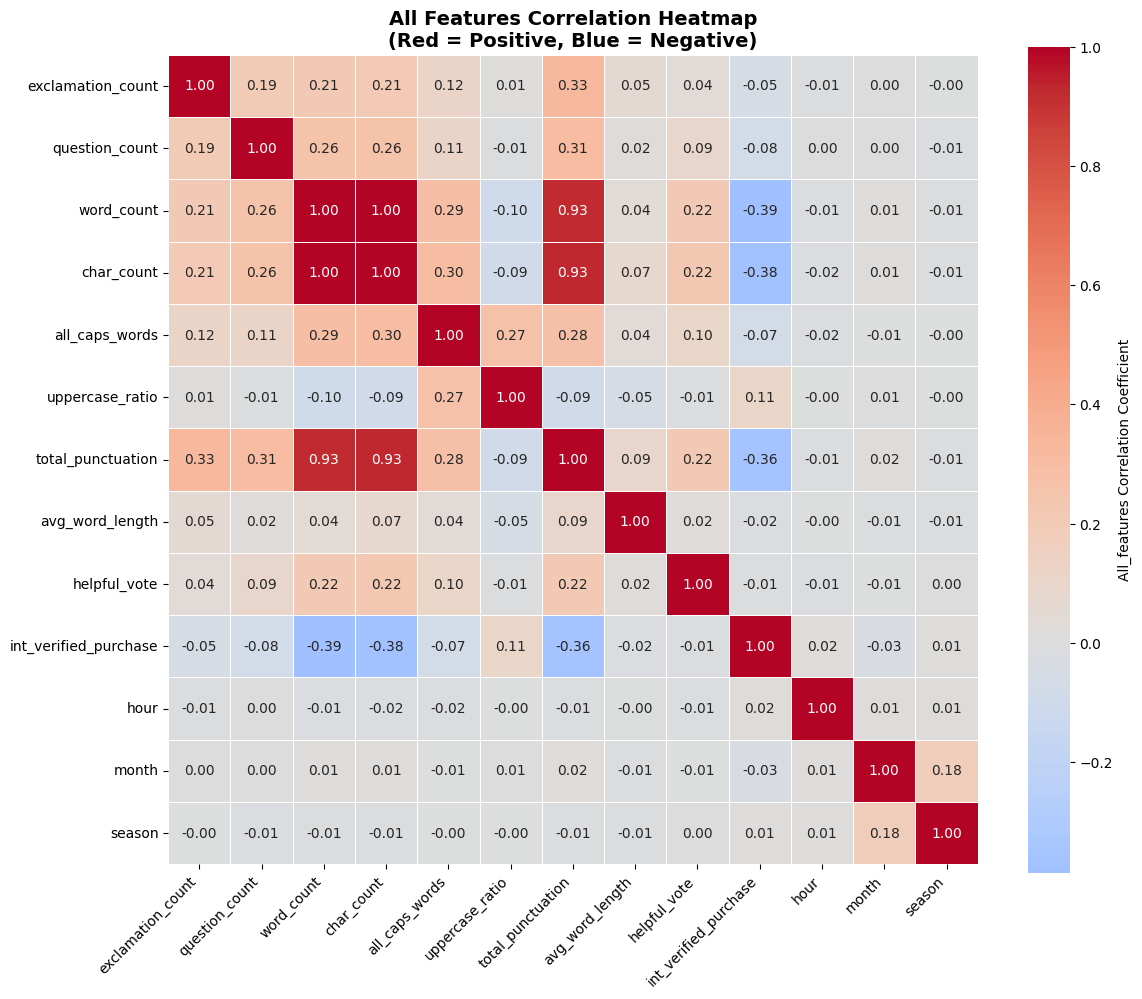

In [14]:
# Create correlation matrix
corr_matrix = df[features].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix,
            annot=True,           # Show correlation values
            fmt='.2f',            # 2 decimal places
            cmap='coolwarm',      # Color scheme
            center=0,             # Center colormap at 0
            square=True,          # Make cells square
            linewidths=0.5,       # Grid lines
            cbar_kws={'label': 'All_features Correlation Coefficient'})

plt.title('All Features Correlation Heatmap\n(Red = Positive, Blue = Negative)',
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
# Save the file
plt.savefig("multicolinarity_heatmap2.png", dpi=300, bbox_inches='tight')
plt.show()